In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, color
from skimage.measure import regionprops
from skimage.morphology import label
import pickle
from cellpose import models, io
from scipy.ndimage import label, find_objects, center_of_mass
import matplotlib.pyplot as plt

In [ ]:
import scipy.io
mat_file_pathGT = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train_GT.mat'
mat_file_path = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train.mat'
mat_contentsGT = scipy.io.loadmat(mat_file_pathGT)
mat_contents = scipy.io.loadmat(mat_file_path)

X = []
Y = []
for i in range(45):
    X.append(mat_contents['ISBI_Train'][i][0])
    Y.append(mat_contentsGT['train_Nuclei'][i][0])
input_image_array = X[12:13]
input_image =X[12]

In [ ]:
io.logger_setup()
cytoplasm_model_path = '/content/drive/MyDrive/Cell-Segmentation/cytoplasm_segmentation_model.pkl'
# Load the model from the file
with open(cytoplasm_model_path, 'rb') as f:
    cytoplasm_segmentation_model = pickle.load(f)
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
nucleus_model = load_model('/content/drive/MyDrive/Cell-Segmentation/nucleus_segmentation_model.h5', custom_objects={'iou_metric': iou_metric})
predict = nucleus_model.predict(np.expand_dims(np.expand_dims(input_image, axis=-1), axis=0))

# Assuming 'predict[0]' is your image with possibly an extra dimension
nucleus_segmented_image = predict[0]

# If your image has an extra dimension (like (512, 512, 1)), reduce it
if nucleus_segmented_image.ndim == 3 and nucleus_segmented_image.shape[2] == 1:
    nucleus_segmented_image = np.squeeze(nucleus_segmented_image)  # This changes shape from (512, 512, 1) to (512, 512)

# Apply thresholding (adjust `threshold_value` as necessary)
threshold_value = 0.5
binary_image = nucleus_segmented_image > threshold_value

# Label connected components, extracting the labeled array
labeled_image, _ = label(binary_image) # Extract the labeled array from the tuple

# Calculate the centroids and create masks for each labeled region
regions = regionprops(labeled_image)

# Create a dictionary to hold masks and centroids for each nucleus
nucleus_info = {}

for region in regions:
    # Create a mask for the current region
    mask = np.zeros_like(binary_image, dtype=bool)
    for coord in region.coords:
        mask[coord[0], coord[1]] = True

    # Store mask and centroid in dictionary with label as the key
    nucleus_info[region.label] = {
        'mask': mask,
        'centroid': (int(region.centroid[0]), int(region.centroid[1]))
    }
mask , _ ,_  = cytoplasm_segmentation_model.eval(input_image,diameter=180, channels=[0,0])
unique_labels = np.unique(mask)

# Create a dictionary to store each mask and its centroid
cytoplasm_info = {}

for label_id in unique_labels:
    if label_id == 0:
        continue  # Skip the background label if it's 0

    # Create a binary mask for the current label
    binary_mask = (mask == label_id).astype(np.uint8)

    # Calculate the centroid using center_of_mass
    centroid = center_of_mass(binary_mask)

    # Store mask and centroid in dictionary with label as the key
    cytoplasm_info[label_id] = {
        'mask': binary_mask,
        'centroid': centroid
    }
# Define a function to calculate Euclidean distance
def euclidean_distance(centroid1, centroid2):
    return np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)

# Initialize the cell info dictionary
cell_info = {}

# Temporary copy of cytoplasm_info to modify during iteration
temp_cytoplasm_info = cytoplasm_info.copy()

# Assign each nucleus to the closest cytoplasm
for nucleus_label, nucleus_data in list(nucleus_info.items()):
    nucleus_centroid = nucleus_data['centroid']
    closest_cytoplasm_label = None
    min_distance = float('inf')

    # Iterate over cytoplasm to find the closest one
    for cytoplasm_label, cytoplasm_data in temp_cytoplasm_info.items():
        cytoplasm_centroid = cytoplasm_data['centroid']
        distance = euclidean_distance(nucleus_centroid, cytoplasm_centroid)

        if distance < min_distance:
            min_distance = distance
            closest_cytoplasm_label = cytoplasm_label

    # Store details in cell_info and remove entries from original dictionaries
    if closest_cytoplasm_label is not None:
        cell_info[nucleus_label] = {
            'nucleus_mask': nucleus_data['mask'],
            'nucleus_centroid': nucleus_centroid,
            'cytoplasm_label': closest_cytoplasm_label,
            'cytoplasm_mask': temp_cytoplasm_info[closest_cytoplasm_label]['mask'],
            'cytoplasm_centroid': temp_cytoplasm_info[closest_cytoplasm_label]['centroid']
        }

        # Remove assigned nucleus and cytoplasm
        del nucleus_info[nucleus_label]
        del temp_cytoplasm_info[closest_cytoplasm_label]

1/1 [==============================] - 6s 6s/step


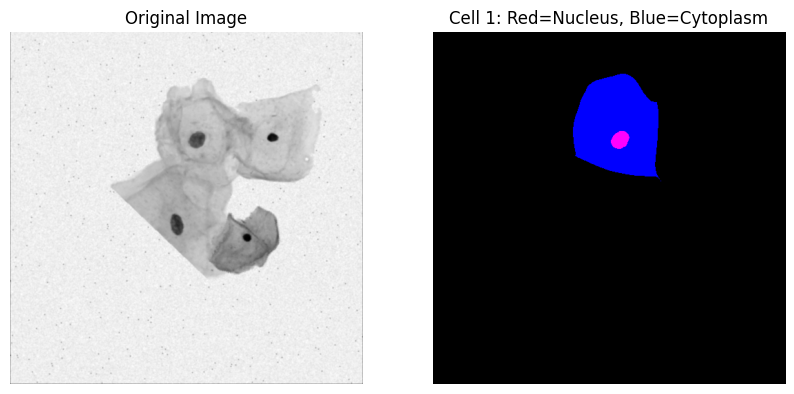

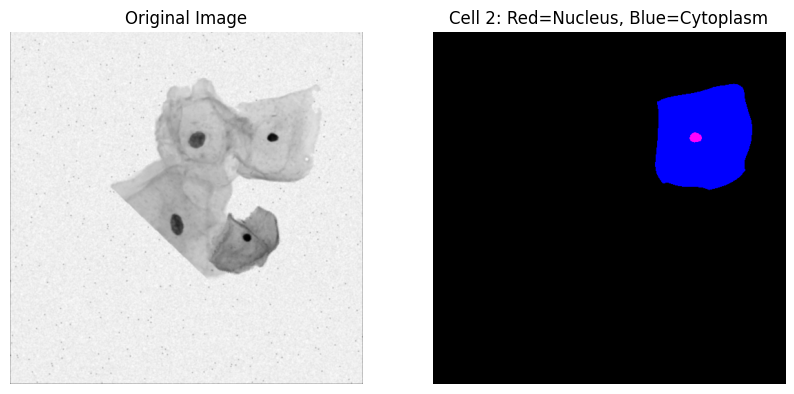

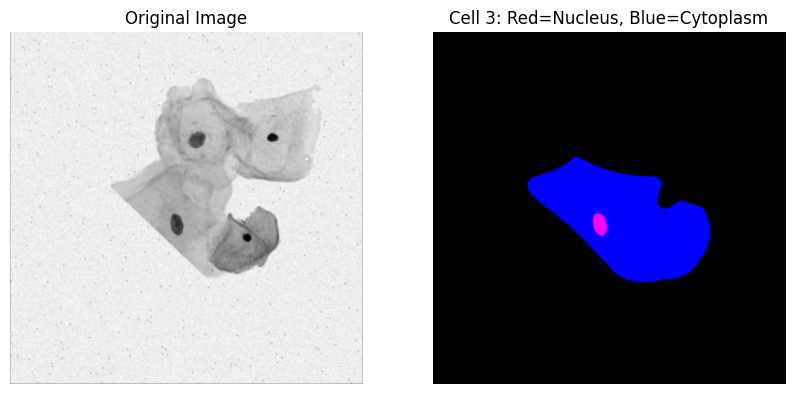

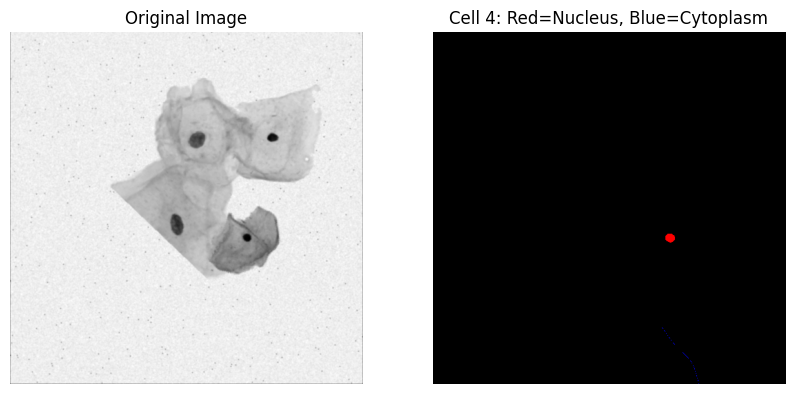

In [ ]:
# Assuming X_test[80] is loaded and accessible here as 'original_image'
original_image = input_image

# Ensure the original image is grayscale for display (if it's not already)
if original_image.ndim == 3 and original_image.shape[2] > 1:
    original_image = original_image[:,:,0]  # Taking the first channel if it's in color

for label, info in cell_info.items():
    # Get the shape of nucleus and cytoplasm masks
    shape = info['nucleus_mask'].shape

    # Create a blank RGB image for cell visualization
    rgb_image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)

    # Assign the red channel to the nucleus mask
    rgb_image[:,:,0] = info['nucleus_mask'] * 255

    # Assign the blue channel to the cytoplasm mask
    rgb_image[:,:,2] = info['cytoplasm_mask'] * 255

    # Plotting both original and mask images side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(rgb_image)
    ax[1].set_title(f'Cell {label}: Red=Nucleus, Blue=Cytoplasm')
    ax[1].axis('off')

    plt.show()
